Target: logerror
logerror = log(Zestimate)−log(SalePrice)

Training data: train_#year.csv <br/>
containing: parcelid, logerror, transactiondate

Property data: property_#year.csv <br/>
containing: 58 features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
from sklearn.preprocessing import MinMaxScaler
color = sns.color_palette()

In [2]:
#Read feature data
pd.options.mode.chained_assignment = None
prop16 = pd.read_csv("../input/properties_2016.csv")
prop17 = pd.read_csv("../input/properties_2017.csv")
train16 = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
train17 = pd.read_csv("../input/train_2017.csv", parse_dates=["transactiondate"])
print("Shape of train data for year 2016: ", train16.shape)
print("Shape of train data for year 2017: ", train17.shape)
print("Shape of property data for year 2016: ", prop16.shape)
print("Shape of property data for year 2017: ", prop17.shape)

C:\Users\adity\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\adity\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape of train data for year 2016:  (90275, 3)
Shape of train data for year 2017:  (77613, 3)
Shape of property data for year 2016:  (2985217, 58)
Shape of property data for year 2017:  (2985217, 58)


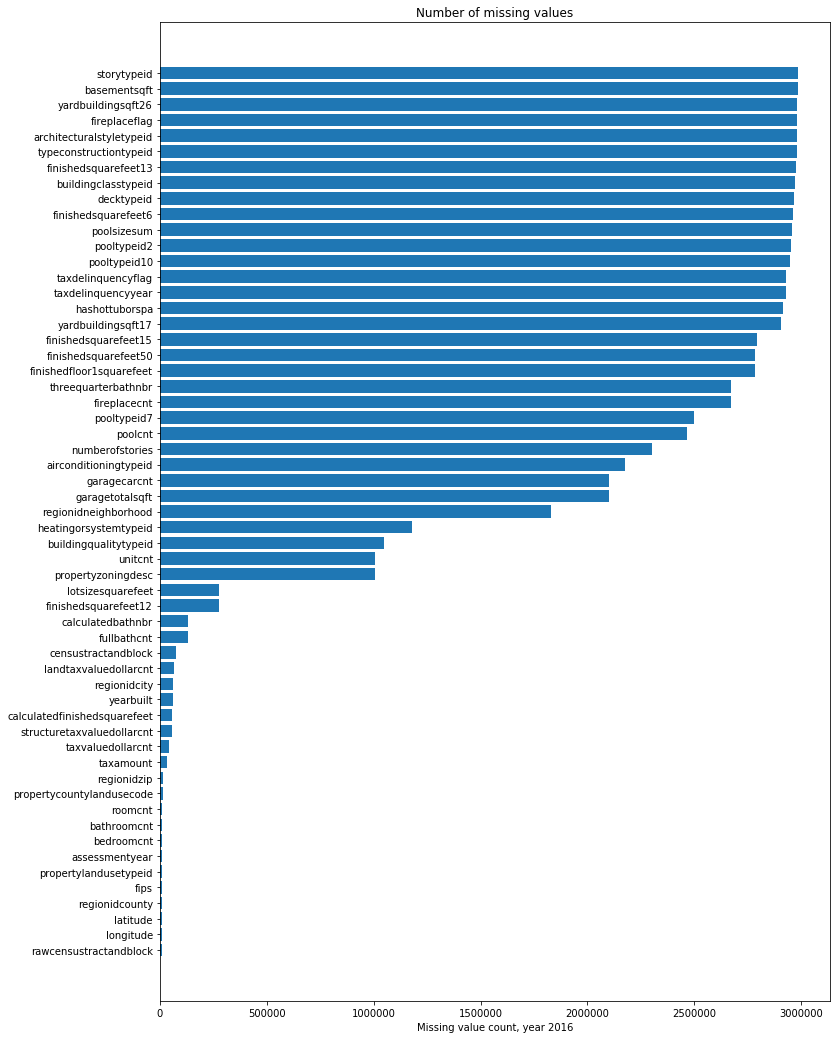

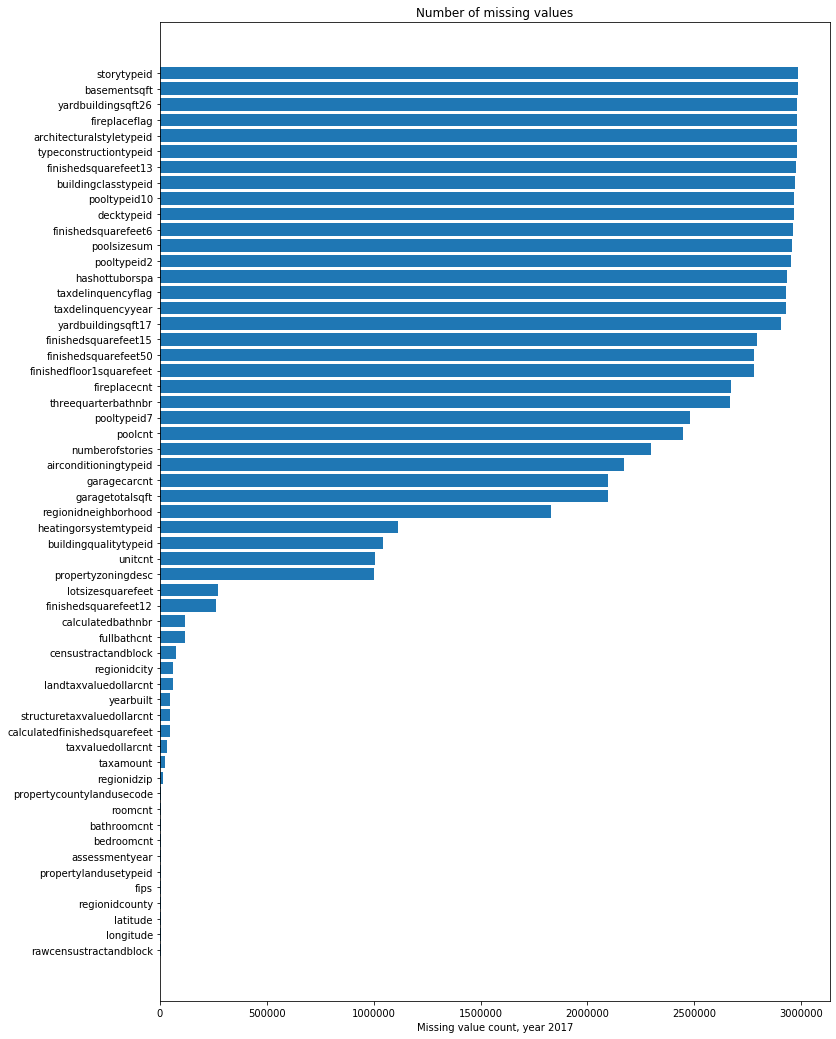

In [3]:
#Analyze missing NaN data in each column
missing_data16 = prop16.isnull().sum(axis=0).reset_index()
missing_data16.columns = ['column_name', 'missing_count']
missing_data16 = missing_data16.loc[missing_data16['missing_count']>0]
missing_data16 = missing_data16.sort_values(by='missing_count')

missing_data17 = prop17.isnull().sum(axis=0).reset_index()
missing_data17.columns = ['column_name', 'missing_count']
missing_data17 = missing_data17.loc[missing_data17['missing_count']>0]
missing_data17 = missing_data17.sort_values(by='missing_count')

index1 = np.arange(missing_data16.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(index1, missing_data16.missing_count.values)
ax.set_yticks(index1)
ax.set_yticklabels(missing_data16.column_name.values)
ax.set_xlabel("Missing value count, year 2016")
ax.set_title("Number of missing values")
plt.show()

index2 = np.arange(missing_data17.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(index2, missing_data17.missing_count.values)
ax.set_yticks(index2)
ax.set_yticklabels(missing_data17.column_name.values)
ax.set_xlabel("Missing value count, year 2017")
ax.set_title("Number of missing values")
plt.show()

We observe that many of the features have most of the data missing. These features would not help in accurate logerror predictions so ignoring those features.

In [4]:
#Checking frequency of parcel ids in train data
print("Year 2016:\n",(train16['parcelid'].value_counts().reset_index())['parcelid'].value_counts())
print("Year 2017:\n",(train17['parcelid'].value_counts().reset_index())['parcelid'].value_counts())

Year 2016:
 1    90026
2      123
3        1
Name: parcelid, dtype: int64
Year 2017:
 1    77218
2      193
3        3
Name: parcelid, dtype: int64


We observe that there are mostly unique records for parcelid.

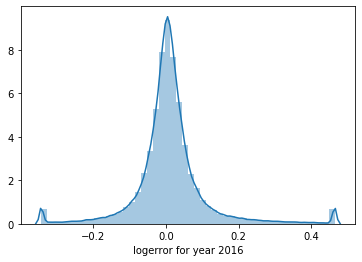

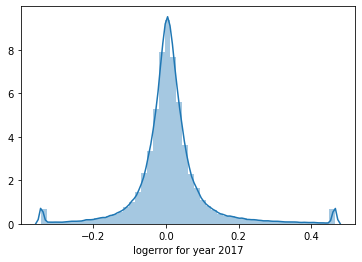

In [12]:
#Plotting logerror histogram after removing outliers

upper = np.percentile(train16.logerror.values, 99)
lower = np.percentile(train16.logerror.values, 1)
train16['logerror'].loc[train16['logerror']>upper] = upper
train16['logerror'].loc[train16['logerror']<lower] = lower

sns.distplot(train16.logerror.values, bins=50)
plt.xlabel('logerror for year 2016')
plt.show()

upper = np.percentile(train17.logerror.values, 99)
lower = np.percentile(train17.logerror.values, 1)
train17['logerror'].loc[train17['logerror']>upper] = upper
train17['logerror'].loc[train17['logerror']<lower] = lower

sns.distplot(train16.logerror.values, bins=50)
plt.xlabel('logerror for year 2017')
plt.show()

We have a normal distribution for logerror for both years

In [6]:
# Merging train and property data to analyze correlation between important features and the target
pd.options.display.max_columns = 999
merge16 = pd.merge(train16, prop16, on='parcelid', how='left')
print("Year 2016:\n")
print(merge16.shape)
merge16.head()

Year 2016:

(90275, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [7]:
merge17 = pd.merge(train17, prop17, on='parcelid', how='left')
print("Year 2017:\n")
print(merge17.shape)
merge17.head()

Year 2017:

(77613, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,14297519,0.025595,2017-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13
1,17052889,0.055619,2017-01-01,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13
2,14186244,0.005383,2017-01-01,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13
3,12177905,-0.103410,2017-01-01,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13
4,10887214,0.006940,2017-01-01,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13


In [14]:
#Analyzing type of data on merged set
type16 = merge16.dtypes.reset_index()
type16.columns = ["Count", "Column Type"]

In [15]:
type16.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,float64,53
2,datetime64[ns],1
3,object,5


Mostly float data

C:\Users\adity\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\adity\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


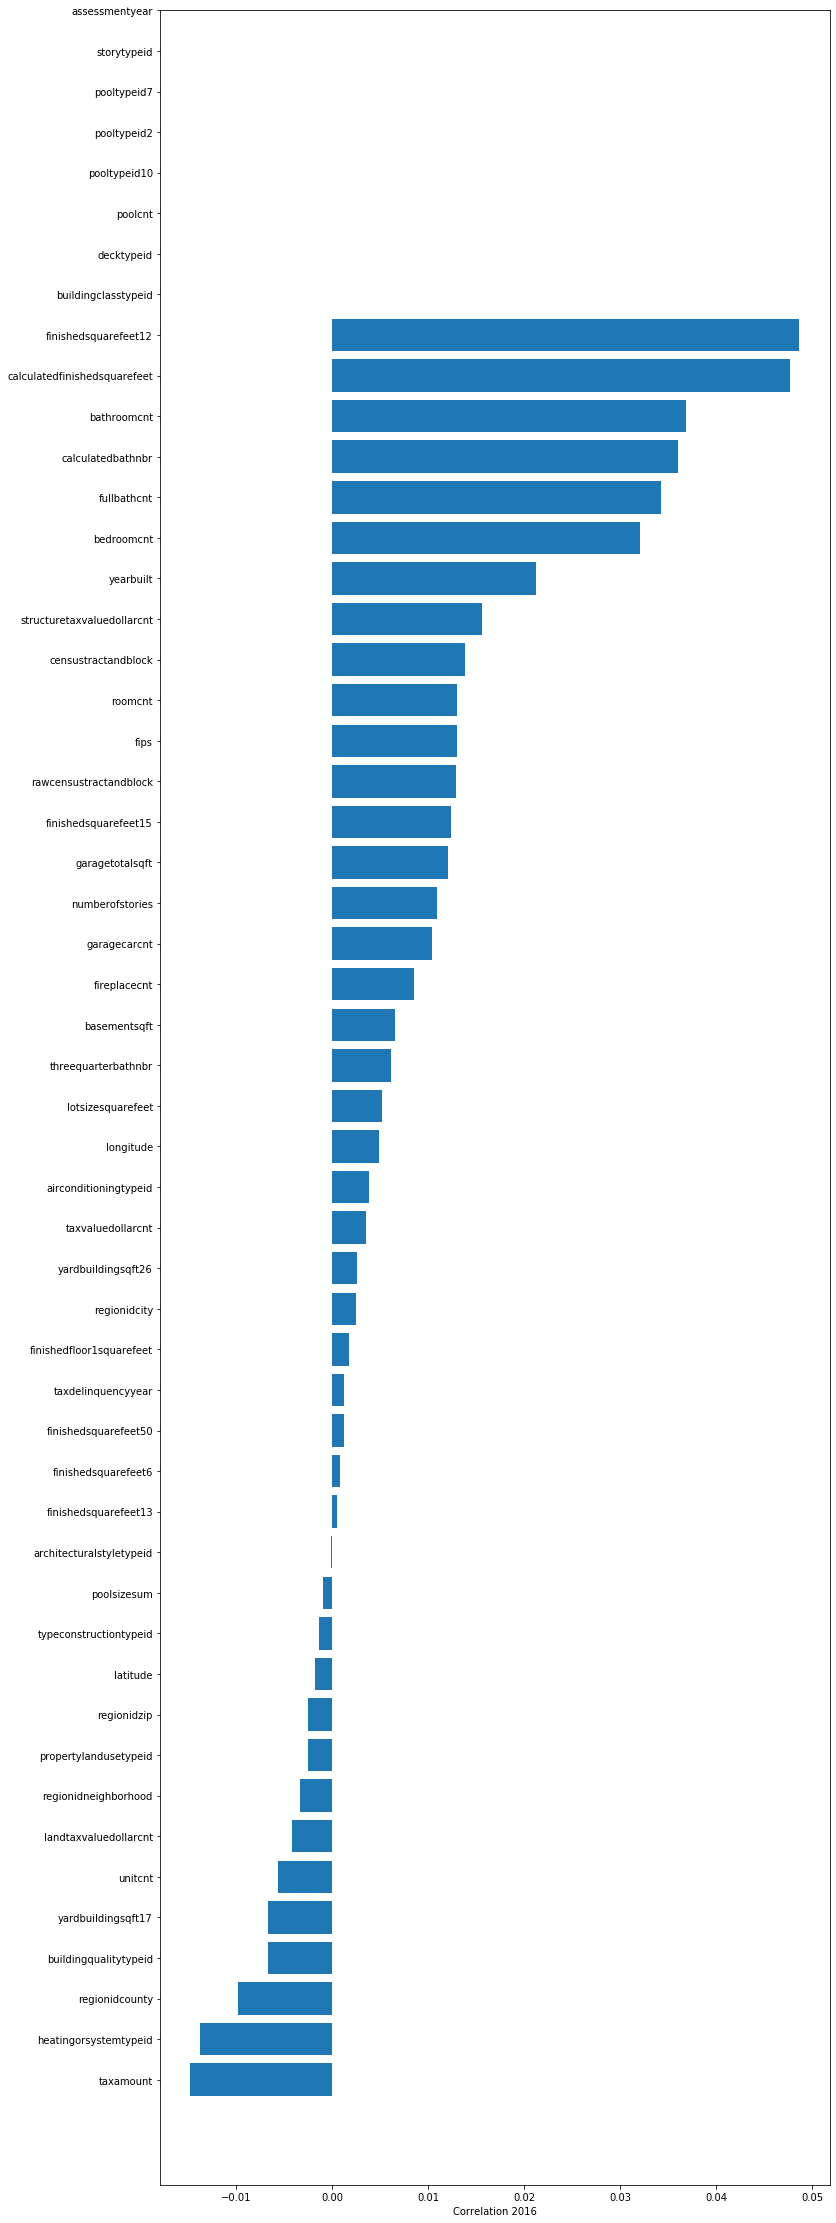

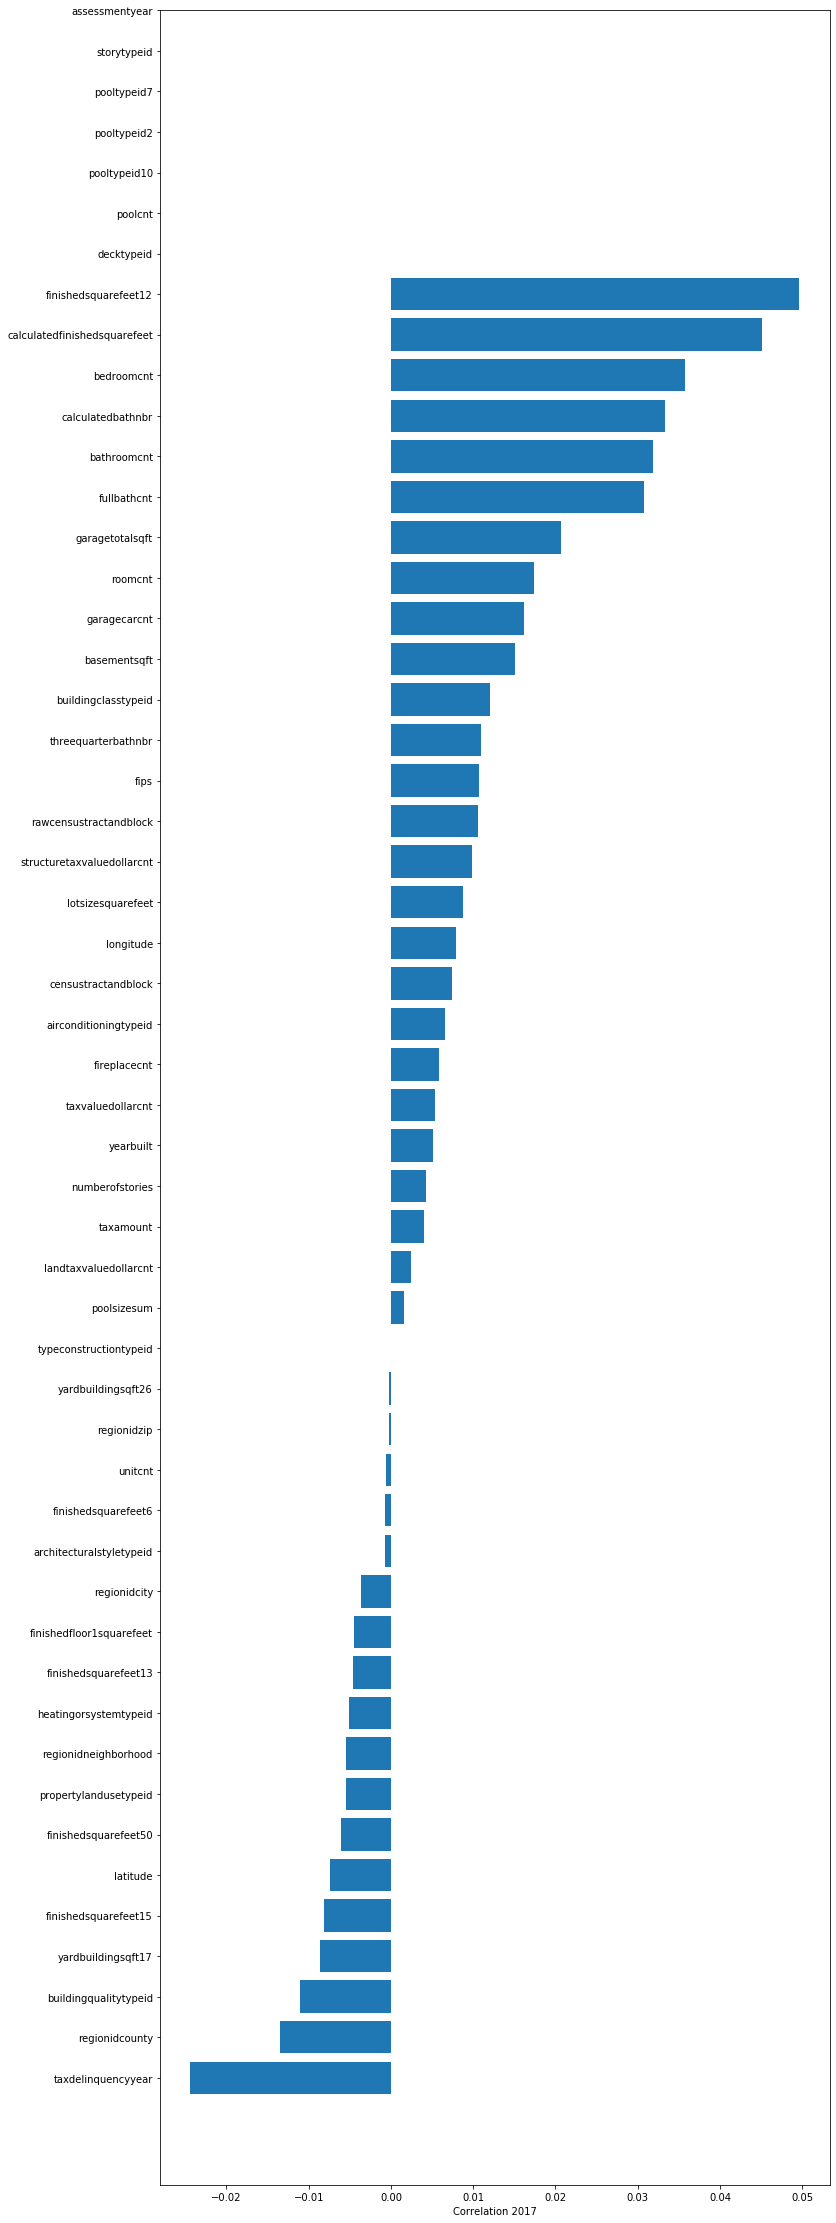

In [16]:
#Plotting correlation of features with target
meanvals = merge16.mean(axis=0)
mergenew16 = merge16.fillna(meanvals)

meanvals = merge17.mean(axis=0)
mergenew17 = merge17.fillna(meanvals)

xcols16 = []
xcols17 = []

#Taking only float values for correlation
for col in mergenew16.columns:
    if col not in ['logerror'] and mergenew16[col].dtype=='float64':
        xcols16.append(col)

for col in mergenew17.columns:
    if col not in ['logerror'] and mergenew17[col].dtype=='float64':
        xcols17.append(col)

        
x16 = []
y16 = []
x17 = []
y17 = []

for col in xcols16:
    x16.append(col)
    y16.append(np.corrcoef(mergenew16[col].values, mergenew16.logerror.values)[0,1])

for col in xcols17:
    x17.append(col)
    y17.append(np.corrcoef(mergenew17[col].values, mergenew17.logerror.values)[0,1])
    
corr16 = pd.DataFrame({'xaxis':x16, 'yaxis':y16})
corr16 = corr16.sort_values(by='yaxis')
    
corr17 = pd.DataFrame({'xaxis':x17, 'yaxis':y17})
corr17 = corr17.sort_values(by='yaxis')

index16 = np.arange(len(x16))
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(index16, np.array(corr16.yaxis.values))
ax.set_yticks(index16)
ax.set_yticklabels(corr16.xaxis.values)
ax.set_xlabel("Correlation 2016")
plt.show()

index17 = np.arange(len(x17))
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(index17, np.array(corr17.yaxis.values))
ax.set_yticks(index17)
ax.set_yticklabels(corr17.xaxis.values)
ax.set_xlabel("Correlation 2017")
plt.show()

In [17]:
# Only choosing features with high correlation to target
corrfinal16 = corr16.loc[(corr16['yaxis']>0.02) | (corr16['yaxis'] < -0.01)]
corrfinal16

,xaxis,yaxis
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


In [18]:
corrfinal17 = corr17.loc[(corr17['yaxis']>0.02) | (corr17['yaxis'] < -0.01)]
corrfinal17

,xaxis,yaxis
50,taxdelinquencyyear,-0.024390
33,regionidcounty,-0.013535
6,buildingqualitytypeid,-0.011012
20,garagetotalsqft,0.020631
18,fullbathcnt,0.030747
3,bathroomcnt,0.031800
7,calculatedbathnbr,0.033346
4,bedroomcnt,0.035700
10,calculatedfinishedsquarefeet,0.045126
11,finishedsquarefeet12,0.049621


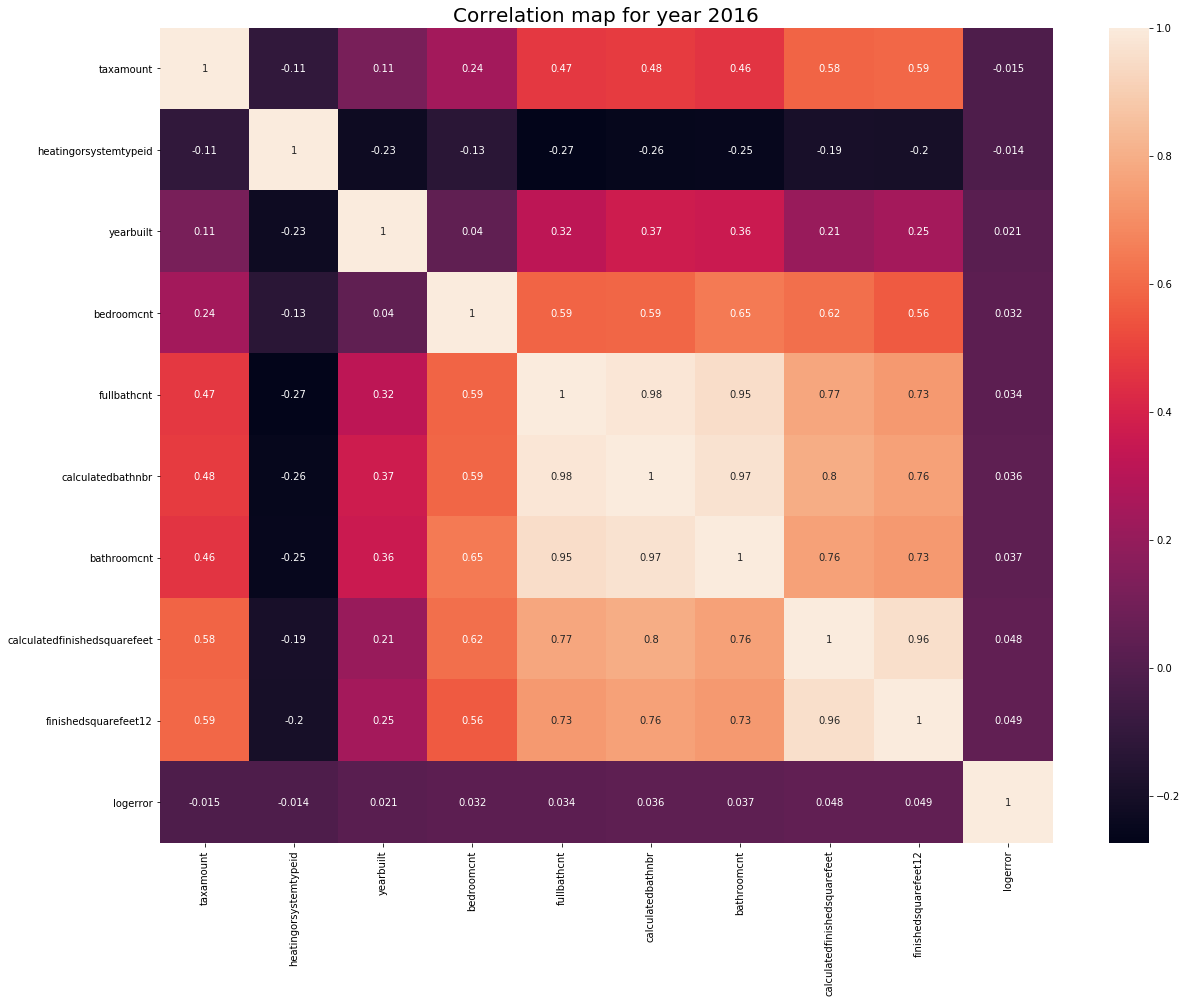

In [19]:
#Plotting correlation map for 2016
a = corrfinal16.xaxis.tolist()
a.append("logerror")
temp16 = mergenew16[a]
sc_data = MinMaxScaler()
x = sc_data.fit_transform(temp16.values)
xtemp16 = pd.DataFrame(x, columns = a, index = temp16.index)
mat = xtemp16.corr()
plt.subplots(figsize=(20, 15))
plt.title("Correlation map for year 2016", fontsize=20)
sns.heatmap(mat, annot=True)

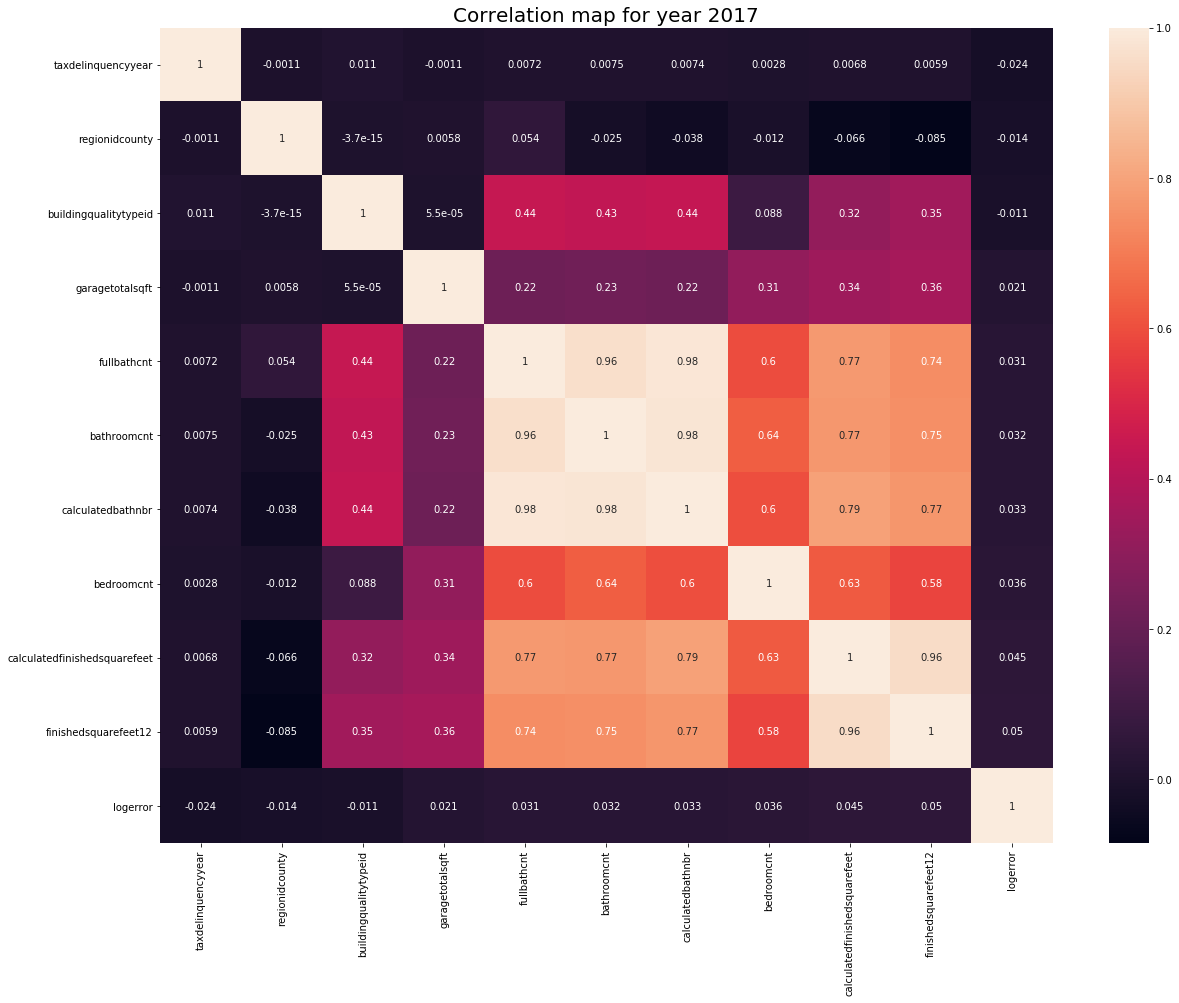

In [20]:
#Plotting correlation map for 2017
b = corrfinal17.xaxis.tolist()
b.append("logerror")
temp17 = mergenew17[b]
sc_data = MinMaxScaler()
x = sc_data.fit_transform(temp17.values)
xtemp17 = pd.DataFrame(x, columns = b, index = temp17.index)
mat = xtemp17.corr()
plt.subplots(figsize=(20, 15))
plt.title("Correlation map for year 2017", fontsize=20)
sns.heatmap(mat, annot=True)

Based on the analysis above we can see that the most important features are <br/>
fullbathcnt <br/>
bathroomcnt <br/>
calculatedbathnbr <br/>
bedroomcnt <br/>
calculatedfinishedsquarefeet <br/>
finishedsquarefeet12 <br/>
<br/>

In the following section we explore correlations using Kendall Tau

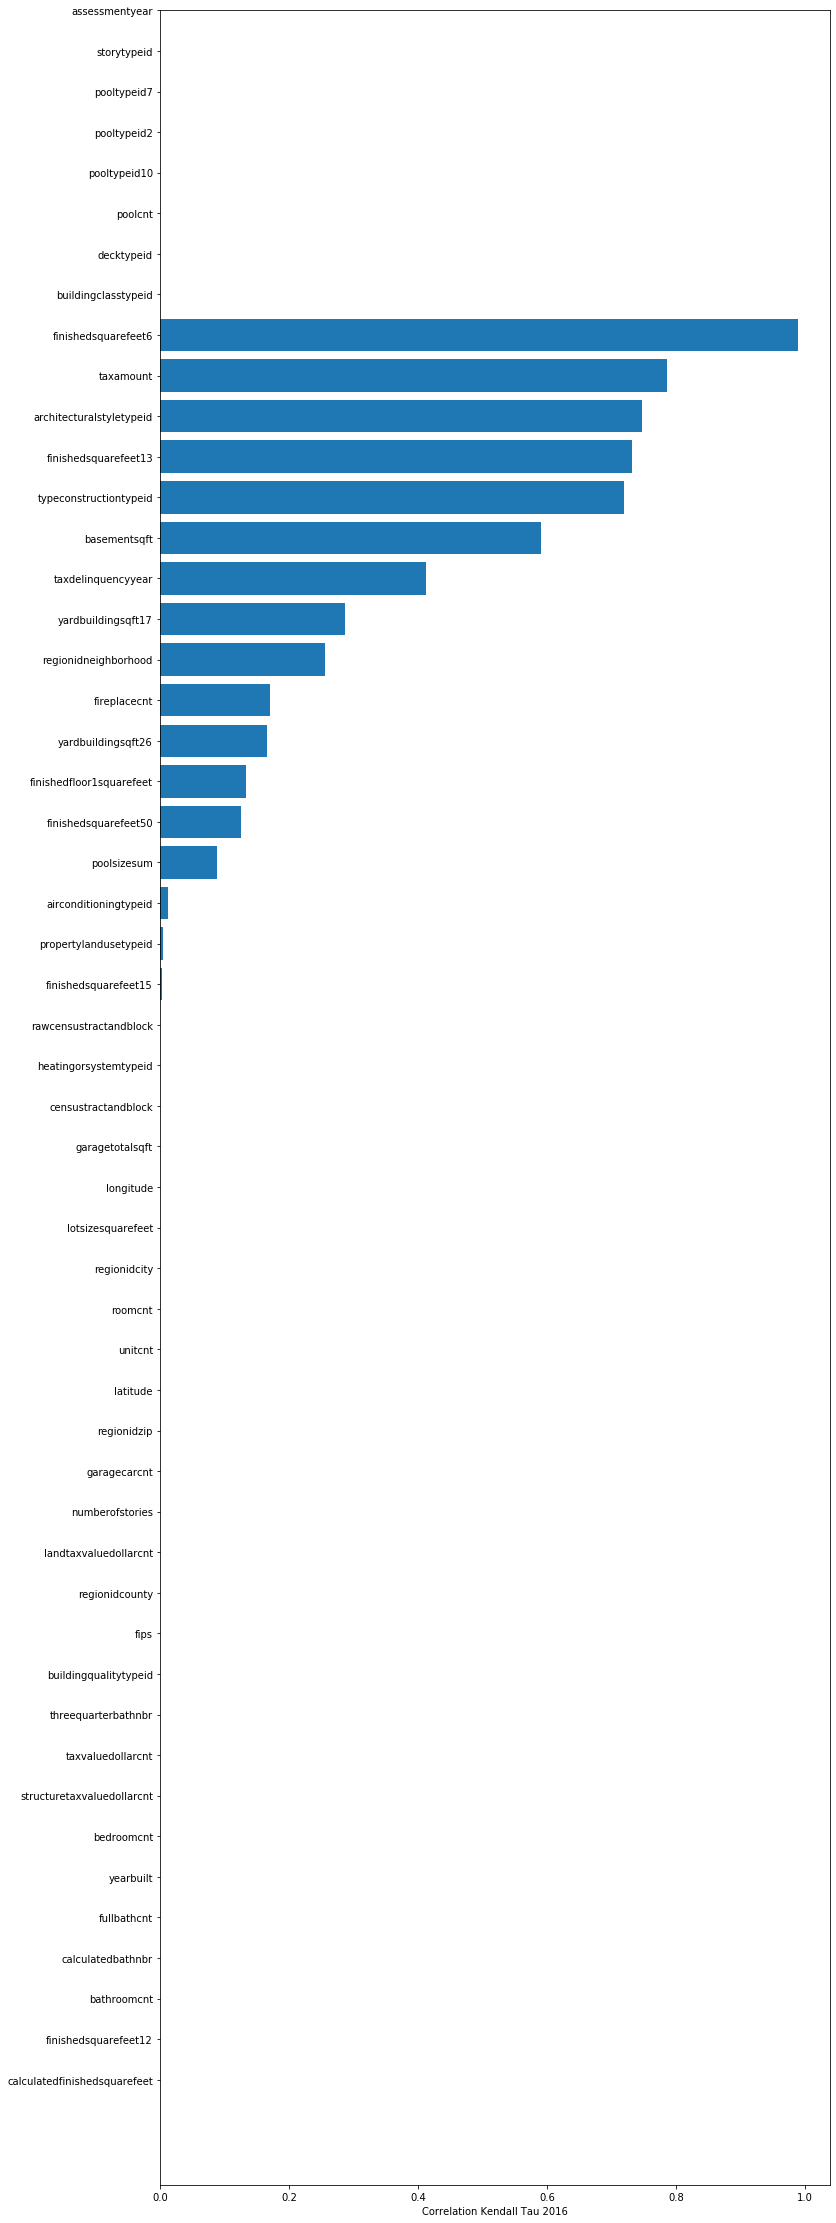

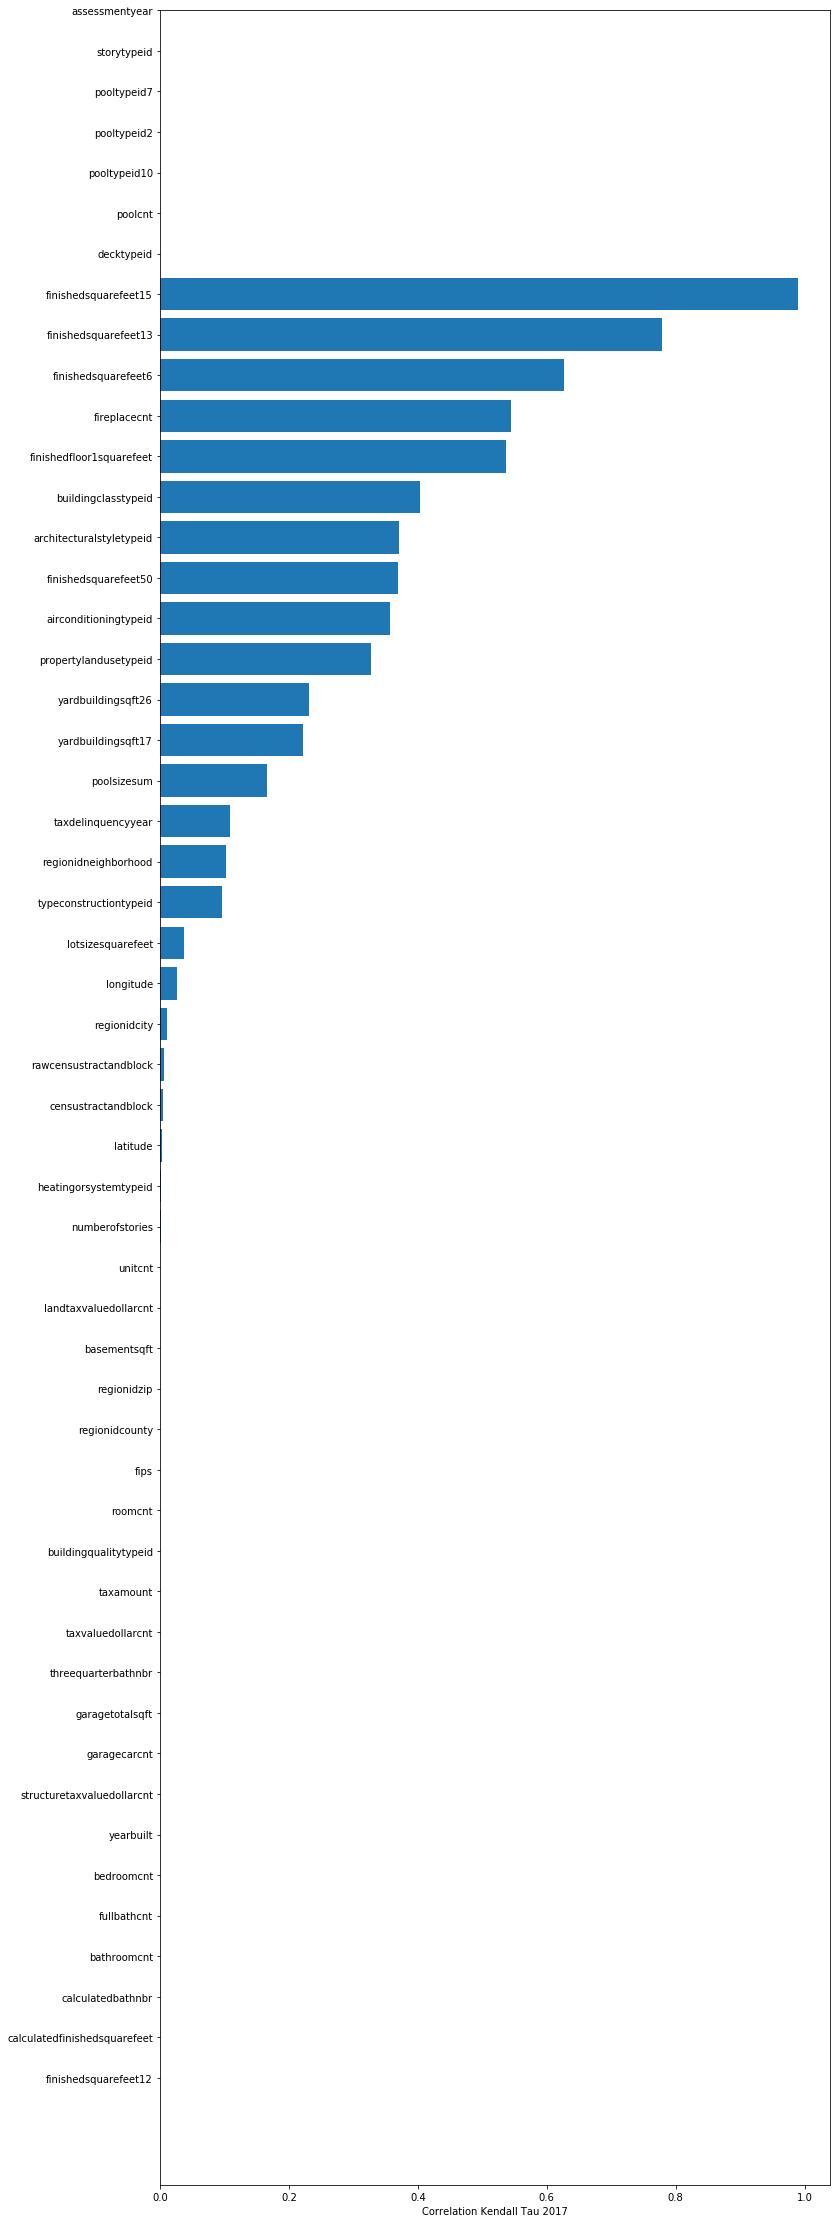

In [21]:
#Plotting correlation of features with target
meanvals1 = merge16.mean(axis=0)
mergenew16_1 = merge16.fillna(meanvals1)

meanvals1 = merge17.mean(axis=0)
mergenew17_1 = merge17.fillna(meanvals1)

xcols16_1 = []
xcols17_1 = []

#Taking only float values for correlation
for col in mergenew16_1.columns:
    if col not in ['logerror'] and mergenew16_1[col].dtype=='float64':
        xcols16_1.append(col)

for col in mergenew17_1.columns:
    if col not in ['logerror'] and mergenew17_1[col].dtype=='float64':
        xcols17_1.append(col)

        
x16_1 = []
y16_1 = []
x17_1 = []
y17_1 = []

for col in xcols16_1:
    x16_1.append(col)
    y16_1.append(scp.stats.kendalltau(mergenew16_1[col].values, mergenew16_1.logerror.values)[1])

for col in xcols17_1:
    x17_1.append(col)
    y17_1.append(scp.stats.kendalltau(mergenew17_1[col].values, mergenew17_1.logerror.values)[1])
    
corr16_1 = pd.DataFrame({'xaxis':x16_1, 'yaxis':y16_1})
corr16_1 = corr16_1.sort_values(by='yaxis')
    
corr17_1 = pd.DataFrame({'xaxis':x17_1, 'yaxis':y17_1})
corr17_1 = corr17_1.sort_values(by='yaxis')

index16 = np.arange(len(x16_1))
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(index16, np.array(corr16_1.yaxis.values))
ax.set_yticks(index16)
ax.set_yticklabels(corr16_1.xaxis.values)
ax.set_xlabel("Correlation Kendall Tau 2016")
plt.show()

index17 = np.arange(len(x17_1))
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(index17, np.array(corr17_1.yaxis.values))
ax.set_yticks(index17)
ax.set_yticklabels(corr17_1.xaxis.values)
ax.set_xlabel("Correlation Kendall Tau 2017")
plt.show()

In [22]:
# Only choosing features with high correlation to target
corrfinal16_1 = corr16_1.loc[(corr16_1['yaxis']>0.02) | (corr16_1['yaxis'] < -0.01)]
corrfinal16_1

,xaxis,yaxis
26,poolsizesum,0.089148
14,finishedsquarefeet50,0.126081
9,finishedfloor1squarefeet,0.134170
42,yardbuildingsqft26,0.166399
17,fireplacecnt,0.171027
34,regionidneighborhood,0.255409
41,yardbuildingsqft17,0.286992
50,taxdelinquencyyear,0.411864
2,basementsqft,0.591115
39,typeconstructiontypeid,0.719658


In [23]:
# Only choosing features with high correlation to target
corrfinal17_1 = corr17_1.loc[(corr17_1['yaxis']>0.02) | (corr17_1['yaxis'] < -0.01)]
corrfinal17_1

,xaxis,yaxis
23,longitude,0.026473
24,lotsizesquarefeet,0.036856
39,typeconstructiontypeid,0.096751
34,regionidneighborhood,0.103172
50,taxdelinquencyyear,0.109365
26,poolsizesum,0.166578
41,yardbuildingsqft17,0.221618
42,yardbuildingsqft26,0.230867
30,propertylandusetypeid,0.326643
0,airconditioningtypeid,0.356264


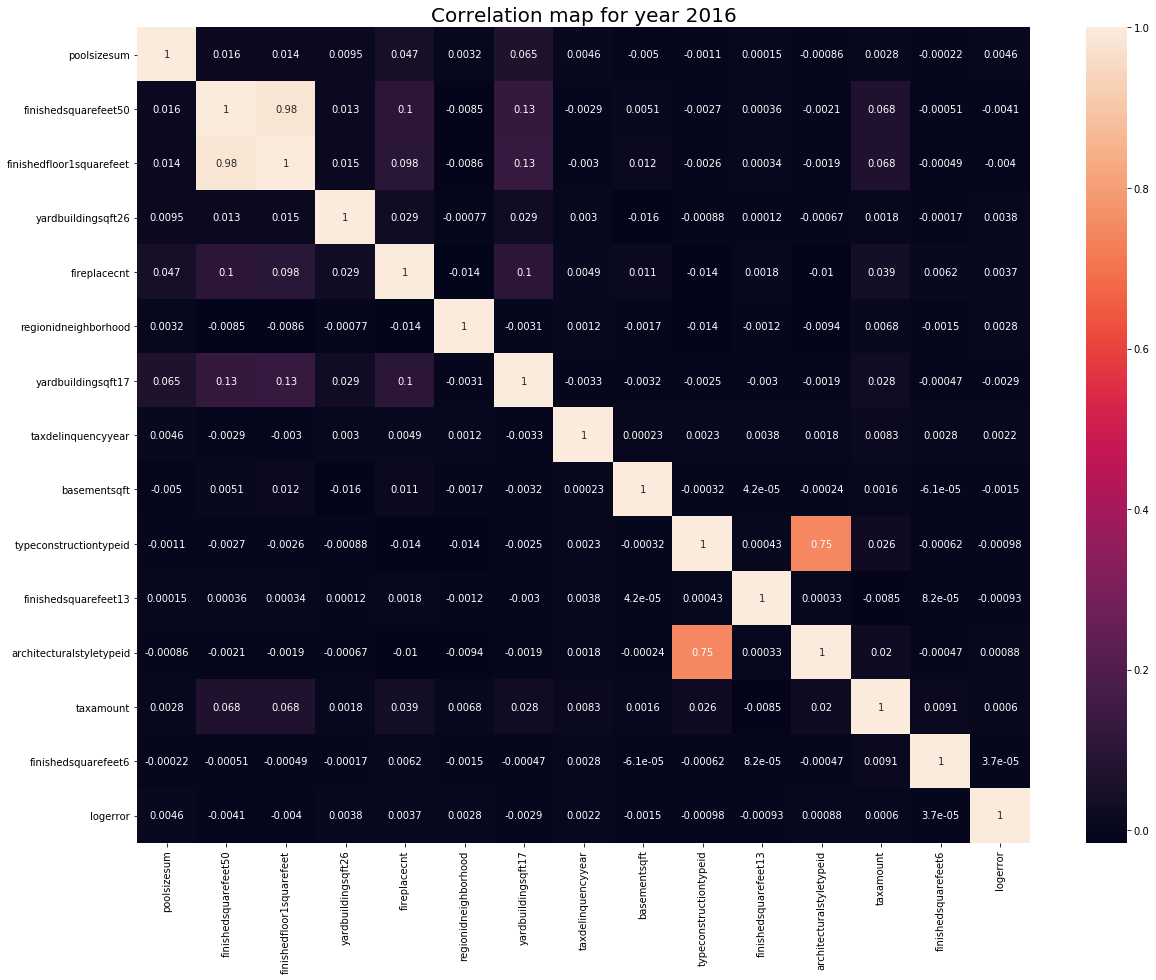

In [24]:
#Plotting correlation map for 2016
a1 = corrfinal16_1.xaxis.tolist()
a1.append("logerror")
temp16_1 = mergenew16_1[a1]
sc_data = MinMaxScaler()
x = sc_data.fit_transform(temp16_1.values)
xtemp16_1 = pd.DataFrame(x, columns = a1, index = temp16_1.index)
mat_1 = xtemp16_1.corr(method="kendall")
plt.subplots(figsize=(20, 15))
plt.title("Correlation map for year 2016", fontsize=20)
sns.heatmap(mat_1, annot=True)

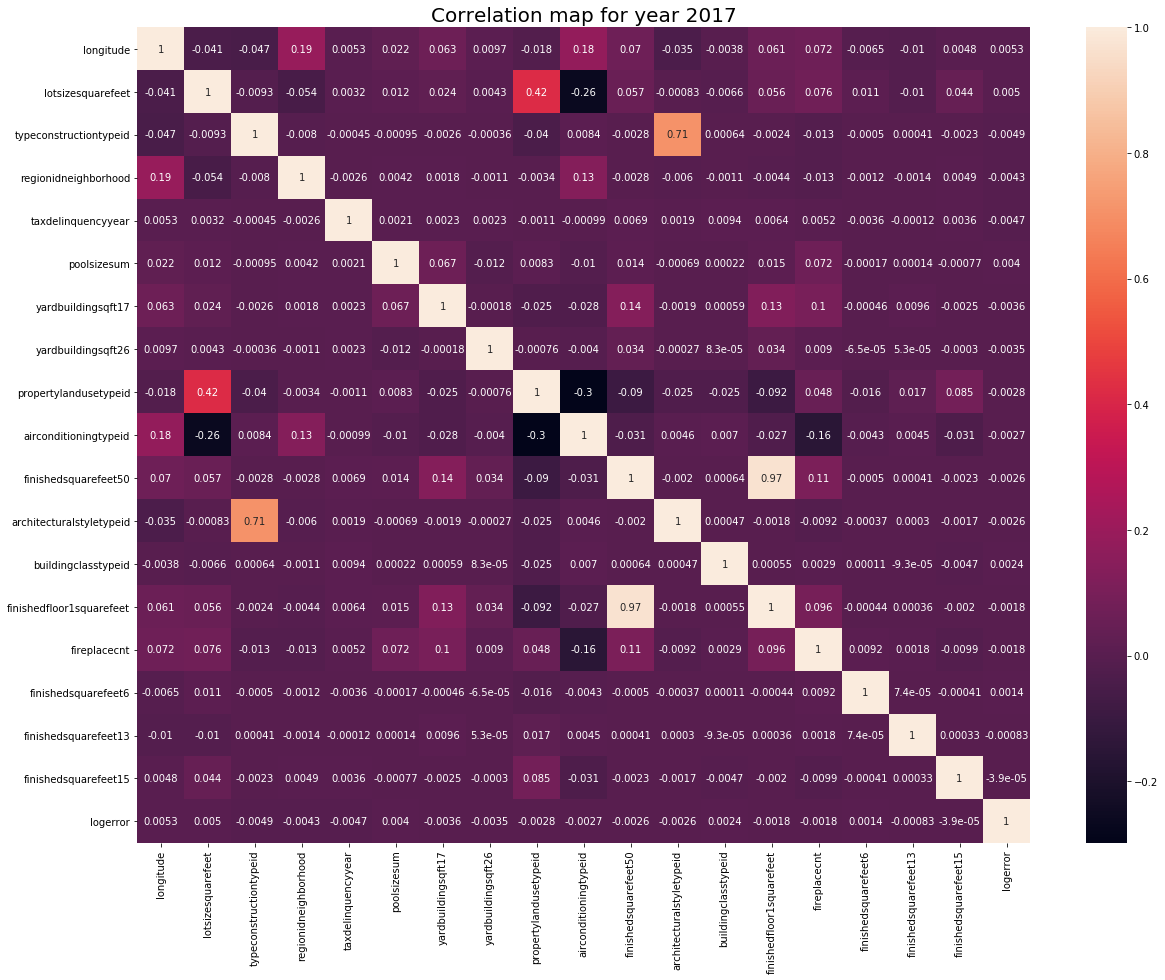

In [25]:
#Plotting correlation map for 2017
b1 = corrfinal17_1.xaxis.tolist()
b1.append("logerror")
temp17_1 = mergenew17_1[b1]
sc_data = MinMaxScaler()
x = sc_data.fit_transform(temp17_1.values)
xtemp17_1 = pd.DataFrame(x, columns = b1, index = temp17_1.index)
mat_1 = xtemp17_1.corr(method="kendall")
plt.subplots(figsize=(20, 15))
plt.title("Correlation map for year 2017", fontsize=20)
sns.heatmap(mat_1, annot=True)